# BERT GRU

En tant que tel, nous allons utiliser la library transformers pour obtenir des transformers pré-entraînés et les utiliser comme couches d'embeddings. Nous allons geler le transformer et entraîner uniquement le reste du modèle qui apprend des représentations produites par le transformer. Dans ce cas, nous utiliserons un GRU bidirectionnel multicouche.

## Préparer les données

In [1]:
import torch

import random
import numpy as np
from torchtext import datasets
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Le transformer a déjà été formé avec un vocabulaire spécifique, ce qui signifie que nous devons nous entraîner avec exactement le même vocabulaire et également symboliser nos données de la même manière que le transformer l'a fait lors de son apprentissage initial.

Le transformer a également été formé avec des tokens spéciaux pour marquer le début et la fin de la phrase. Ainsi qu'avec les tokens : pad et unk. 

In [2]:
len(tokenizer.vocab)

init_token = tokenizer.cls_token
eos_token = tokenizer.sep_token
pad_token = tokenizer.pad_token
unk_token = tokenizer.unk_token

print(init_token, eos_token, pad_token, unk_token)

[CLS] [SEP] [PAD] [UNK]


Le modèle a été formé sur des séquences d'une longueur maximale définie qui vaut 512. 

In [3]:
max_input_length = tokenizer.max_model_input_sizes['bert-base-uncased']

print(max_input_length)
def tokenize_and_cut(sentence):
    tokens = tokenizer.tokenize(sentence) 
    tokens = tokens[:max_input_length-2] # car les tokens de début et de fin deront ajoutés
    return tokens

init_token_idx = tokenizer.cls_token_id
eos_token_idx = tokenizer.sep_token_id
pad_token_idx = tokenizer.pad_token_id
unk_token_idx = tokenizer.unk_token_id

print(init_token_idx, eos_token_idx, pad_token_idx, unk_token_idx)

from torchtext import data

TEXT = data.Field(batch_first = True, # le transformer s'attend à ce que la dimension du lot soit la première,
                  use_vocab = False, # nous avons déjà le vocabulaire de notre texte, fourni par le transformer
                  tokenize = tokenize_and_cut,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = init_token_idx,
                  eos_token = eos_token_idx,
                  pad_token = pad_token_idx,
                  unk_token = unk_token_idx)

LABEL = data.LabelField(dtype = torch.float)

512
101 102 0 100


In [4]:
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)
test_data, valid_data = test_data.split(random_state = random.seed(1234))

print(f'Taille des données train: {len(train_data)}')
print(f'Taille des données de validation: {len(valid_data)}')
print(f'Taille des données test: {len(test_data)}')

LABEL.build_vocab(train_data)

Taille des données train: 25000
Taille des données de validation: 7500
Taille des données test: 17500


In [5]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device, sort = False)

## Construire le modèle

In [6]:
from transformers import BertTokenizer, BertModel

bert = BertModel.from_pretrained('bert-base-uncased')

Au lieu d'utiliser une couche embedding pour obtenir des embedding pour notre texte, nous utiliserons le modèle de transformer pré-entraîné. Ces embeddings seront ensuite introduites dans un GRU pour produire une prédiction du sentiment de la phrase d'entrée. Nous obtenons la taille de la dimension d'embedding (appelée hidden_size) du transformer via son attribut de configuration. 

In [7]:
import torch.nn as nn

class BERTGRUSentiment(nn.Module):
    def __init__(self,
                 bert,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.bert = bert
        
        embedding_dim = bert.config.to_dict()['hidden_size']
        
        self.rnn = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [batch size, sent len]
                
        with torch.no_grad():
            embedded = self.bert(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        
        _, hidden = self.rnn(embedded)
        
        #hidden = [n layers * n directions, batch size, emb dim]
        
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
                
        #hidden = [batch size, hid dim]
        
        output = self.out(hidden)
        
        #output = [batch size, out dim]
        
        return output


In [8]:
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25

model = BERTGRUSentiment(bert,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [9]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 112,241,409 paramètres à entraîner


Afin de figer les paramètres (et non de les entraîner), nous devons définir leur attribut `requires_grad` sur `False`. Pour ce faire, nous parcourons simplement tous les named_parameters de notre modèle et s'ils font partie du modèle de transformer de bert, nous définissons `require_grad = False`.

In [10]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,759,169 trainable parameters


On obtient ainsi un nombre de paramètres semblables à nos autres modèles.

## Entraînement

In [11]:
import torch.optim as optim

def optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
            'weight_decay_rate': weight_decay_rate},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
            'weight_decay_rate': second_weight_decay_rate}]
    return optim.Adam(
        optimizer_grouped_parameters,
        lr=lr,
        eps=eps
    )

optimizer = optimiseur(model, lr=1e-4, eps=1e-6, weight_decay_rate=0.001, second_weight_decay_rate=0.0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

def binary_accuracy(preds, y):

    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)
              
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [12]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

tloss = []
tacc = []
vloss = []
vacc = []

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    tloss.append(train_loss)
    tacc.append(train_acc) 
    scheduler.step()
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    vloss.append(valid_loss)
    vacc.append(valid_acc)   
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tutgru-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')



Epoch: 01 | Epoch Time: 9m 56s
	Train Loss: 0.558 | Train Acc: 70.26%
	 Val. Loss: 0.387 |  Val. Acc: 83.56%
Epoch: 02 | Epoch Time: 9m 58s
	Train Loss: 0.360 | Train Acc: 85.12%
	 Val. Loss: 0.302 |  Val. Acc: 87.20%
Epoch: 03 | Epoch Time: 9m 58s
	Train Loss: 0.310 | Train Acc: 87.12%
	 Val. Loss: 0.259 |  Val. Acc: 89.60%
Epoch: 04 | Epoch Time: 9m 59s
	Train Loss: 0.279 | Train Acc: 88.70%
	 Val. Loss: 0.264 |  Val. Acc: 89.12%
Epoch: 05 | Epoch Time: 9m 58s
	Train Loss: 0.258 | Train Acc: 89.50%
	 Val. Loss: 0.239 |  Val. Acc: 90.46%
Epoch: 06 | Epoch Time: 9m 59s
	Train Loss: 0.247 | Train Acc: 90.09%
	 Val. Loss: 0.220 |  Val. Acc: 91.39%
Epoch: 07 | Epoch Time: 9m 55s
	Train Loss: 0.231 | Train Acc: 90.92%
	 Val. Loss: 0.223 |  Val. Acc: 91.36%
Epoch: 08 | Epoch Time: 9m 57s
	Train Loss: 0.225 | Train Acc: 91.05%
	 Val. Loss: 0.225 |  Val. Acc: 91.76%
Epoch: 09 | Epoch Time: 9m 58s
	Train Loss: 0.216 | Train Acc: 91.39%
	 Val. Loss: 0.209 |  Val. Acc: 91.61%
Epoch: 10 | Epoch T

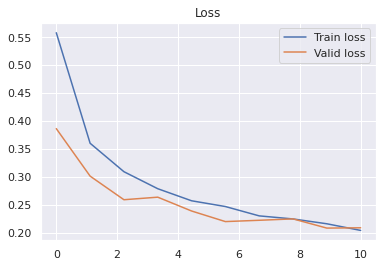

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tloss)
plt.plot(x,vloss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

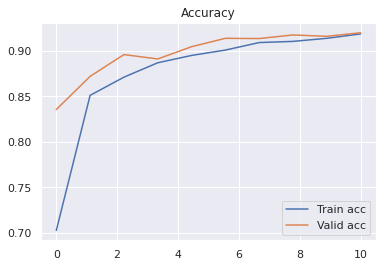

In [14]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,tacc)
plt.plot(x,vacc)
plt.title("Accuracy")
plt.legend(["Train acc", "Valid acc"])

## Test

In [15]:
model.load_state_dict(torch.load('tutgru-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.205 | Test Acc: 91.84%


In [16]:
import torch.nn.functional as F
def predict_sentiment(model, sentence):
    model.eval()
    tokens = tokenizer.tokenize(sentence)
    tokens = tokens[:max_input_length-2]
    indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    prediction = model(tensor)
    out = F.softmax(prediction, 1)
    if (prediction.item() > 0.5):
        print ("Sentiment: Positive")
    else:
        print ("Sentiment: Negative")

predict_sentiment(model, "this film is not good ")

Sentiment: Negative


In [17]:
predict_sentiment(model, "This film is great amazing ")

Sentiment: Positive


In [18]:
predict_sentiment(model, "This film is terrible ")

Sentiment: Negative


## Référence : 

 - https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/6%20-%20Transformers%20for%20Sentiment%20Analysis.ipynb